In [1]:
# ! pip install pyspark pandas numpy

  Using cached pyspark-3.5.1-py2.py3-none-any.whl
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 3.8 MB/s eta 0:00:00a 0:00:01


# Introduction
As highlighted in the accompanying blog post, "effective risk management requires real-time water risk data that is continuously fed into risk models". This is true. What is *also* true, is that using real-time data without any quality checks on that data poses threats to the validity of model outputs. We've all heard some version of the adage, "data quality in equals data quality out".

In most cases, there is a tradeoff between utilizing  data with the lowest possible latency and ensuring the data has been put through rigorous quality testing. Divirod addresses this issue by implementing data quality checks and standardization as data is ingested into the data lake in real time. Data quality scores are assigned for *every* data point in the Divirod data lake during the ingestion processes. This removes a huge burden for users of this data. 

For example, yes, modelers can query their own data from both USGS and NOAA to feed into water risk models. But is that data standardized? What about unit conversions? How do you know if the data set contains outliers from faulty gauges, etc.?  The USGS and NOAA readings for your region of interest from just this morning? In the data lake - already standardized, quality checked, outliers and discontinuities flagged, and accessible to you from a single end point! 



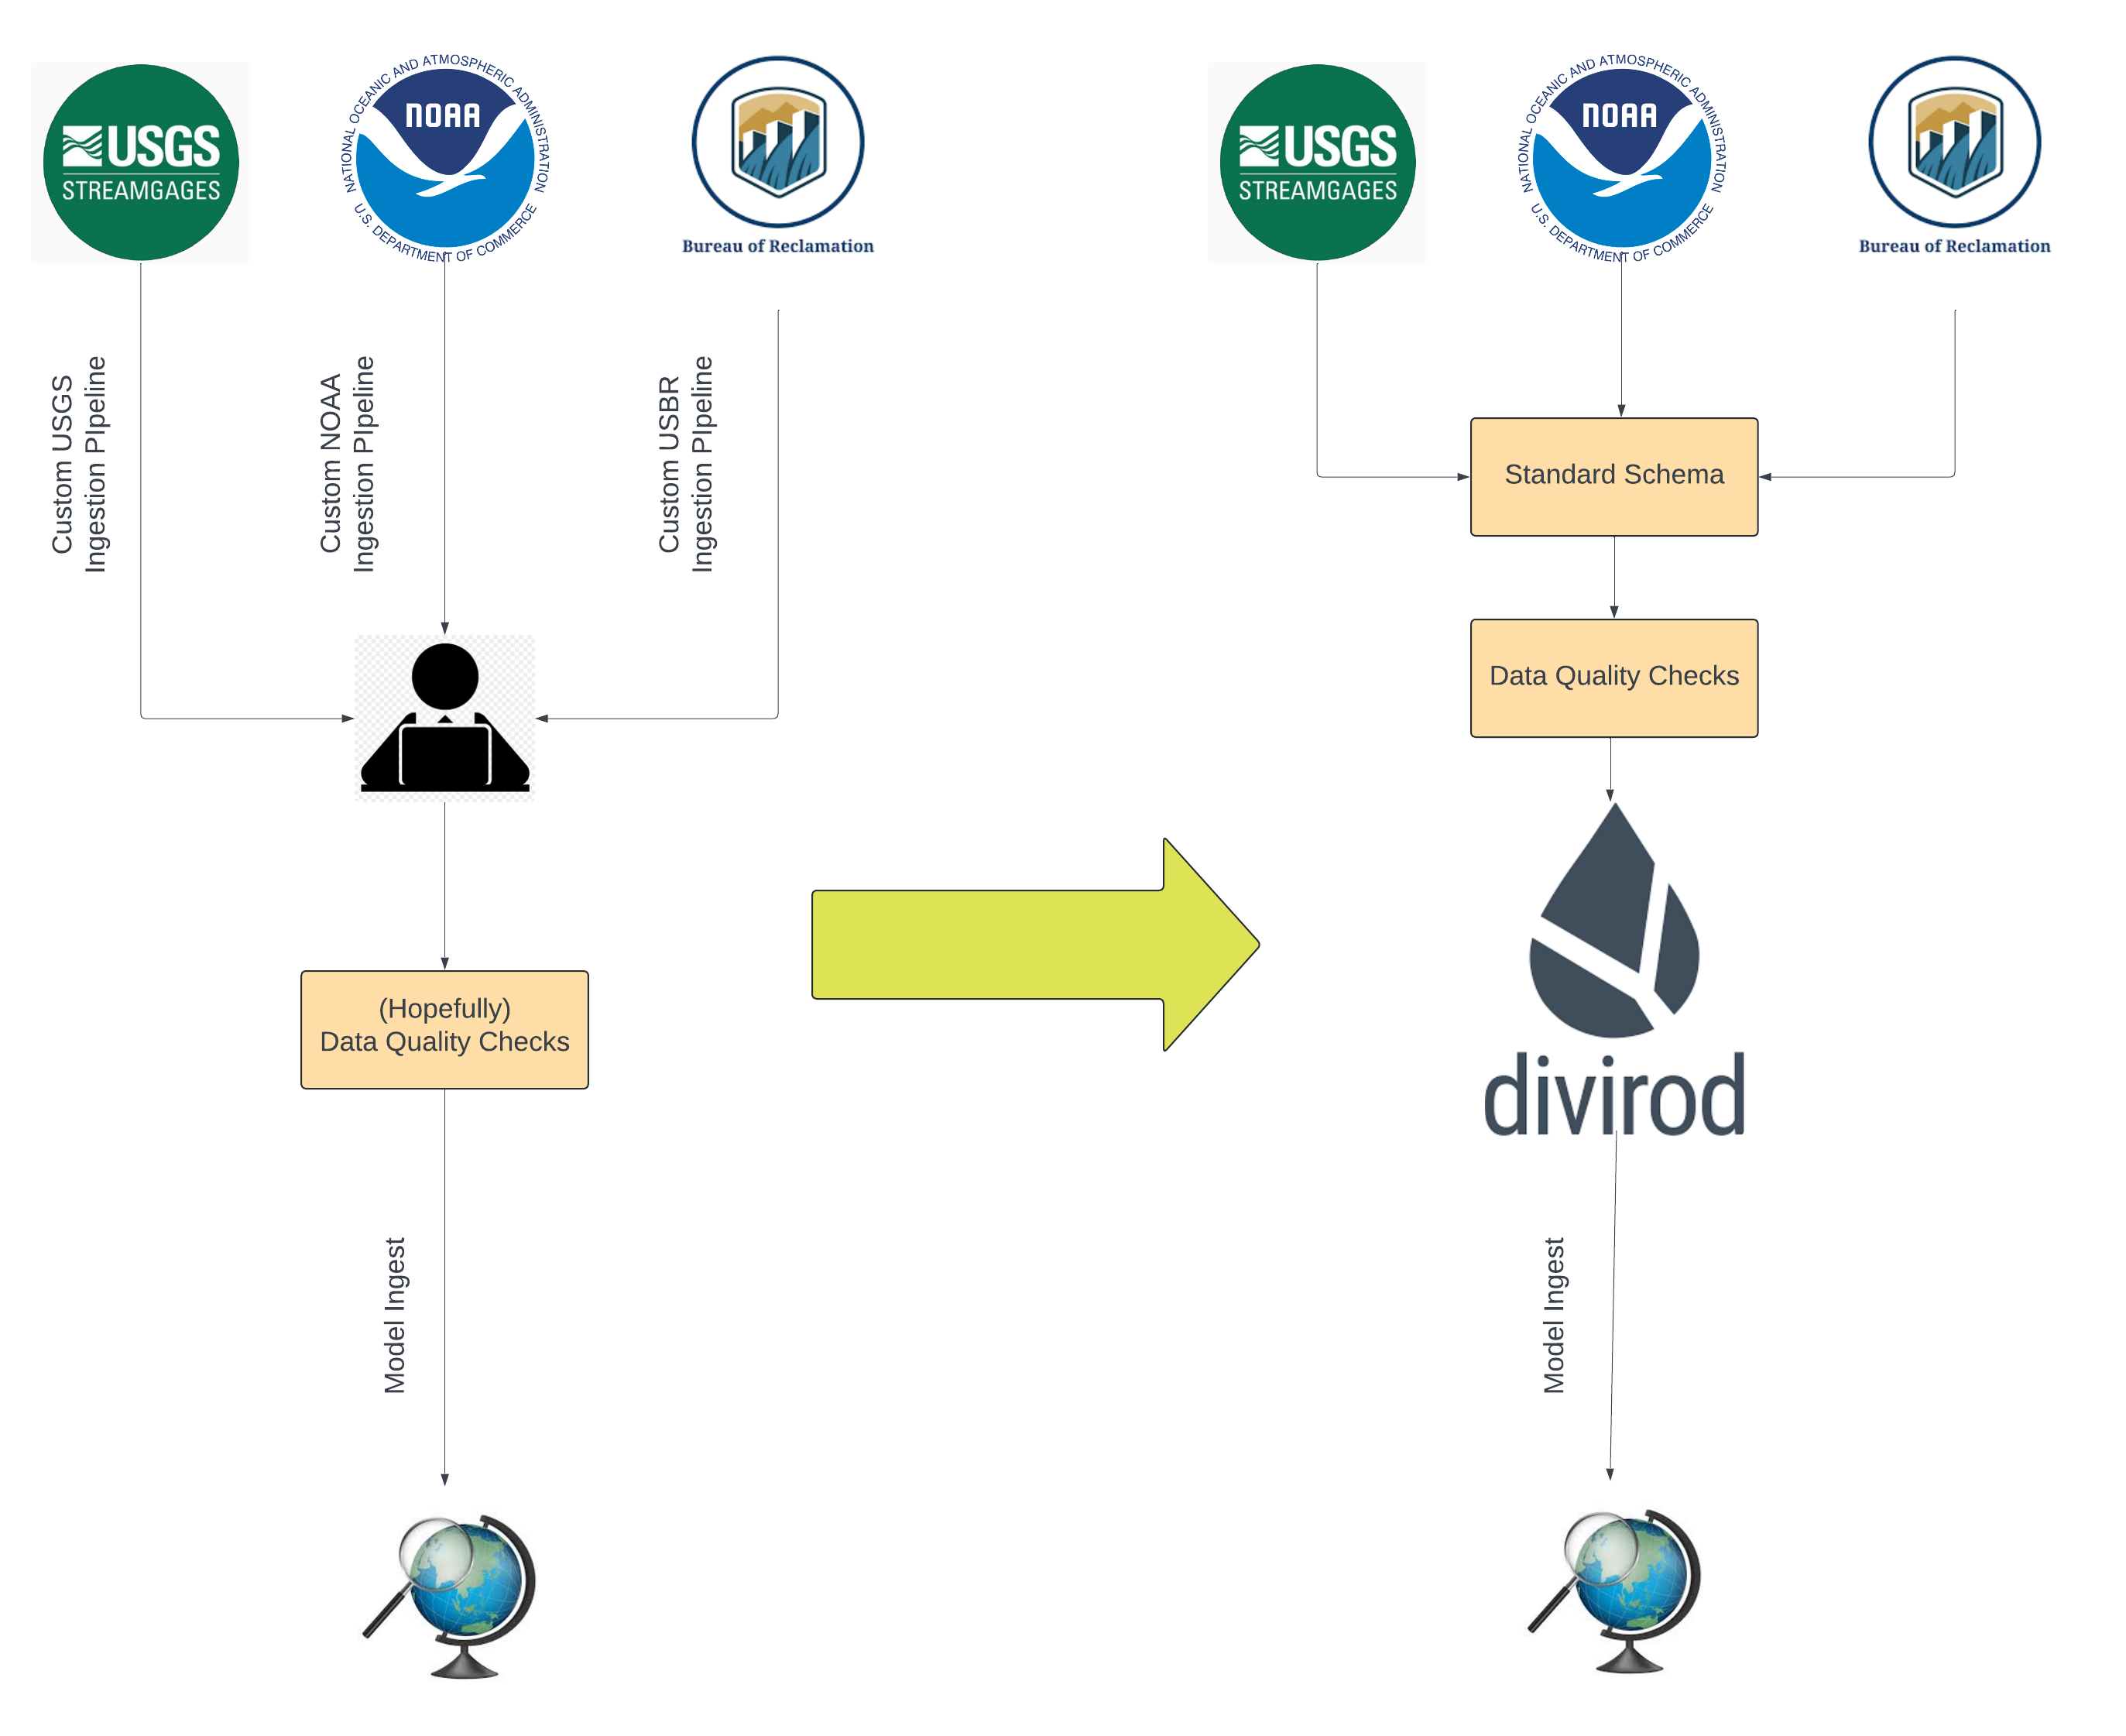

In [18]:
# @hidden_cell
import base64
from IPython.display import HTML

image_path = './../images/divirod_data_diagram.png'

# Function to get Base64 string of an image
def get_image_base64(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

image_base64 = get_image_base64(image_path)

# Create an HTML string with the Base64 embedded and width set to 100%
html = f'<img src="data:image/jpg;base64,{image_base64}" style="width:100%;">'

# Display the image in the notebook
display(HTML(html))

# Goal
The purpose of this notebook is to provide transparency for customers as to how Divirod uses the Databricks platform in combination with Spark streaming to couple low latency with high standards for data quality checks. Divirod continuously ingests, standardizes, and quality checks 30 million water measurements daily across 20,000 + locations from providers around the globe using Spark Streaming; this notebook is mean to give a glimpse as to how we do that, and give customers confidence in our data processing pipeline. The goals of this accelerator notebook are three-fold:

* Provide transparency for (part of) Divirod's data quality pipeline implemented as part of the ingestion pipeline
* Highlight how implementing these checks during the ingestion process with spark streaming addresses the traditional tradeoff between ensuring high data quality and utilizing low latency data for model inputs.
* Provide a technical example, for those interested, on how data scientists and developers can implement similar checks on ingestion pipelines constructed within the Databricks platform.

This notebook will contain a combination of detailed code for execution of this process, as well as explanatory text intermingled throughout.

The below graphic serves as a reference to where the content within this notebook sits in relation to Divirod's overall data ingestion pipeline. 


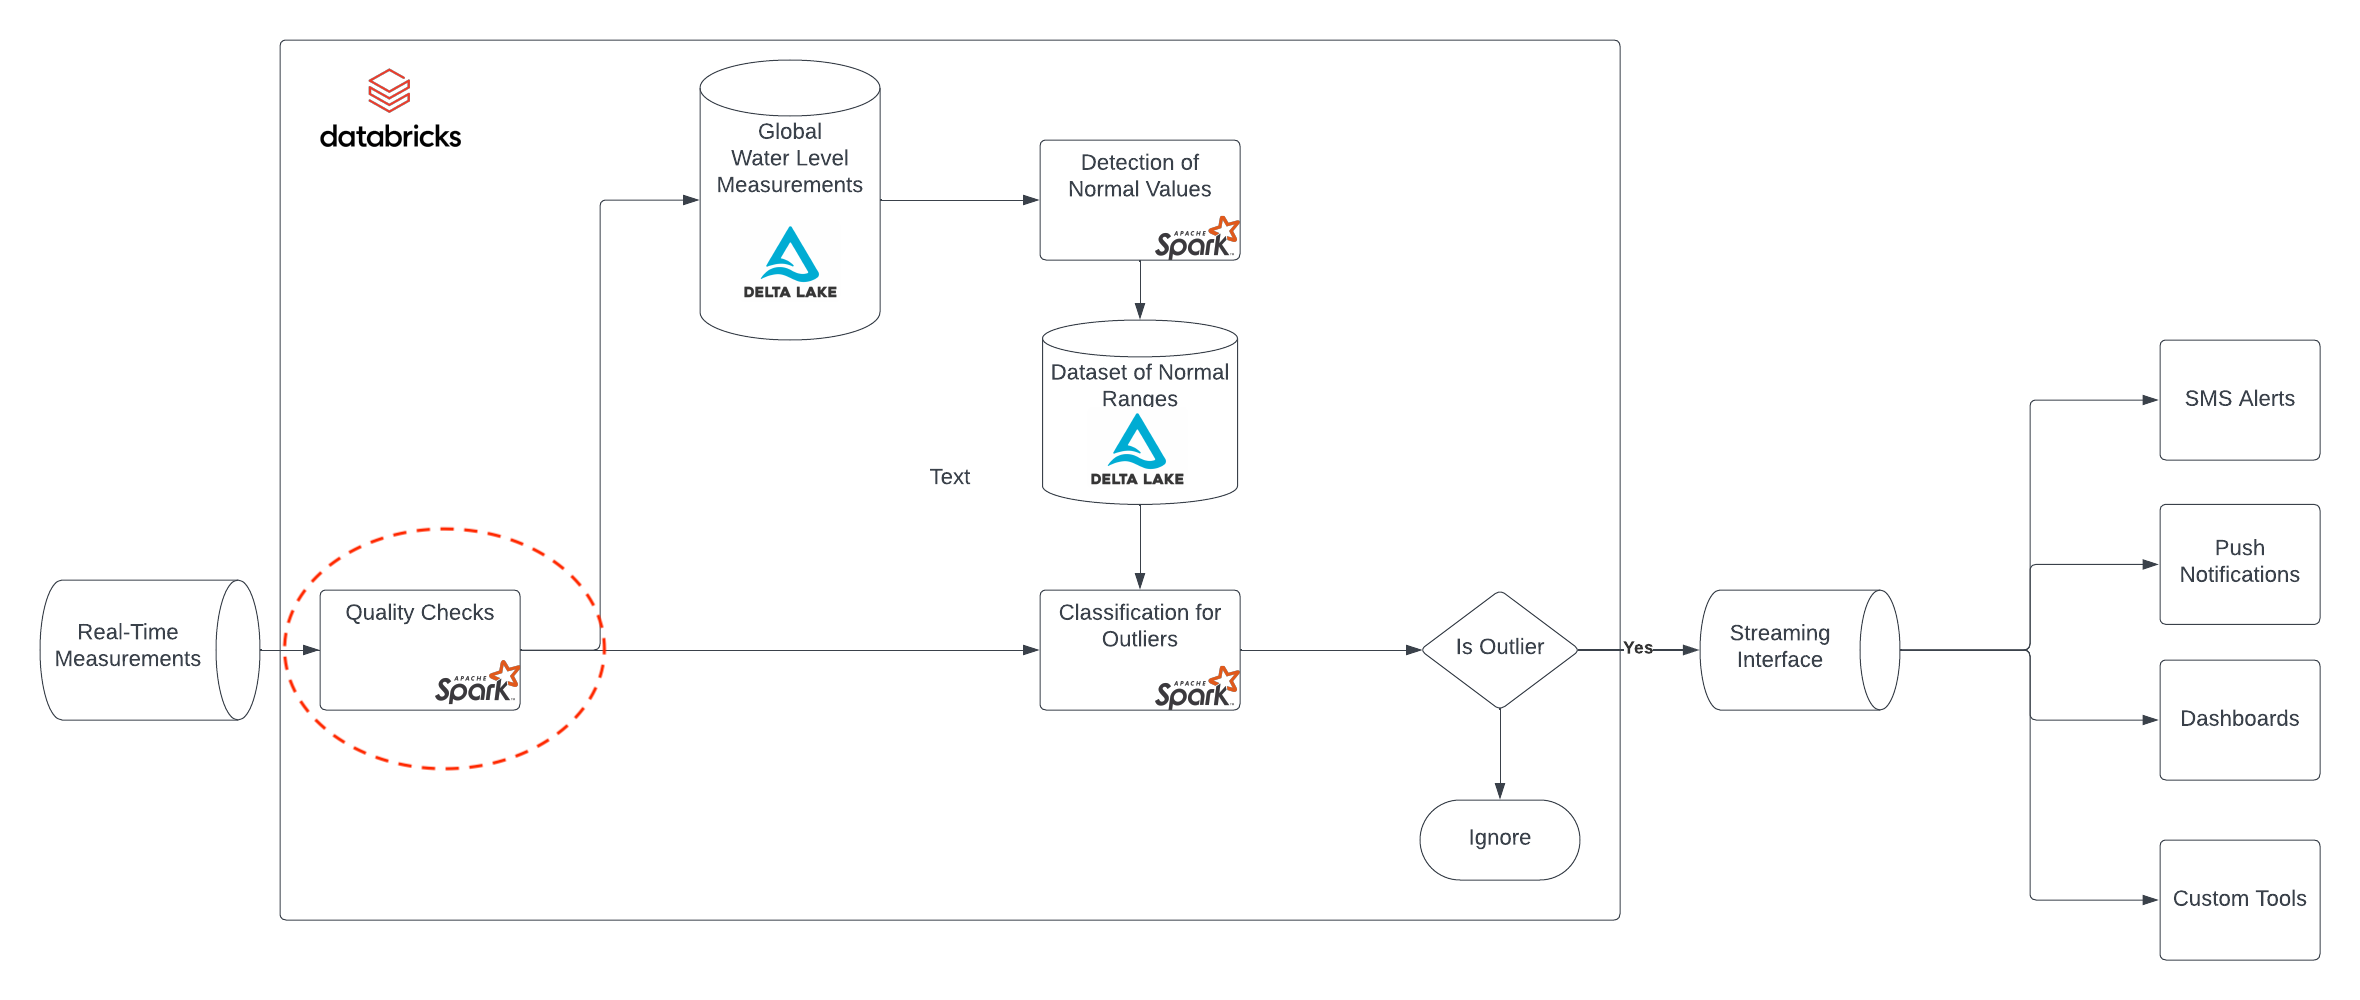

In [19]:
import base64
from IPython.display import HTML

image_path = './../images/architecture_diagram_qual_checks.png'

# Function to get Base64 string of an image
def get_image_base64(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

image_base64 = get_image_base64(image_path)

# Create an HTML string with the Base64 embedded and width set to 100%
html = f'<img src="data:image/jpg;base64,{image_base64}" style="width:100%;">'

# Display the image in the notebook
display(HTML(html))

# Example Workflow Explanation

Divirod assigns two data quality metrics for each record in the Divirod delta lake as they are ingested. One is to designate a data quality standard, classified as: 'gold', 'silver', or 'bronze'. The other is a diagnostic metric that can be used to identify what specific issues are impacting a record. The purpose of the diagnostic metric is to a) Give insight to operations as to potential sensor issues, and b) Allow users a quick understanding of what data quality issues apply to a specific record. 

**NOTE: Only "Completeness" and "Out of Range" checks are performed in this notebook!**
Divirod also implements checks out discontinuities and physically-invalid data points (outliers).


### Diagnostic
To determine data quality we are checking for four main issues:
* **Incomplete fields**
  * Looks at the completeness level of these priority variables: instrument_id, time, height_native, datum_native, provider_id, last_update
* **Values out of range**
  * Checks for time stamps in the future, impossible combintations for lat/lons, accuracies greater than 1, unknown provider and instrument ids
* **Discontinuous**
  * Checks to make sure that the instrument has not missed any expected data collection intervals. 
* **Physically invalid**
  * Checks to make sure the rate of change over each data interval period is physically plausible.

The diagnostic metric will flag if one (or more) of these data errors is occurring. The diagnostic metric is broken out as follows (note: these are already broken out and interpretable in the summary table)


 * 0 = No issues
 * 1 = Physically invalid
 * 2 = Discontinuous
 * 4 = Values out of range
 * 8 = Incomplete fields
 * 3 = Physically invalid + Discontinuous
 * 5 = Physically invalid + Values out of range
 * 9 = Physically invalid + Incomplete fields
 * 6 = Discontinuous + Values out of range
 * 10 = Discontinuous + Incomplete fields
 * 12 = Values out of range + Incomplete fields
 * 7 = Physically invalid + Discontinuous + Values out of range
 * 11 = Physically invalid + Discontinuous + Incomplete fields
 * 13 = Physically invalid + Values out of range + Incomplete fields
 * 14 = Discontinuous + Values out of range + Incomplete fields
 * 15 = Physically invalid + Discontinuous + Values out of range + Incomplete fields


### Qualitative
We wanted a high level data quality metric that can be easily interpreted both internally and externally to understand the data quality of each record. We landed on ratings of 'gold', 'silver', and 'bronze'. **Important note:** **This is different than Databricks' medallion architecture. Divirod chose this metric because it can be interpreted in a similar manner, but this data quality designation is assigned by Divirod for only the records in Divirod's data lake.**

Gold, silver, and bronze data qualities are defined as follows:

| | Completeness  | Value Ranges  | Continuity  | Physical Correctness  |
|----------|--------------|-----------|------------|-------------|
|Gold| All values present| All values within valid range|All values are continuous|For this type of site, data makes sense|
|Silver| "last_update" can be missing     | May have incorrect lat, lon, or accuracy | A few missing data points, but still able to interpret trends based on site type|Generally, data is plausible|
|Bronze| Anything less than silver| Anything less than silver| Anything less than silver|Anything less than silver|

# Code Example

## Initialization

### Imports

In [11]:
import pyspark.sql.functions as F
from pyspark.sql.functions import when
from pyspark.sql.window import Window
from pyspark.sql import SparkSession
from pyspark.sql.streaming import DataStreamWriter
from pyspark.sql.types import (
    StructType,
    StructField,
    StringType,
    LongType,
    DoubleType,
    BooleanType,
    TimestampType,
    IntegerType,
)

import pandas as pd
import numpy as np
import datetime
from pyspark.sql import SparkSession



# for typing
from pyspark.sql import dataframe as sparkDataFrame

### Stream Configuration
This section simulates the data stream coming out of Divirod's ETL pipeline. The defined schema is a mirror of the schema in Divirod's water_level table in the productionized delta lake. 
These same columns are present for all instruments in the data lake (both Divirod instruments, as well as third party). 

In [7]:
# this file path will be updated to the appropriate path in the github repo
billings_2022_data_path = "./../databricks_solution_accelerator/billings_11074_all_measurements_2022"

In [8]:
billings_data_schema = StructType(
    [
        StructField("instrument_id", IntegerType(), True),
        StructField("epoch", LongType(), True),
        StructField("time", TimestampType(), True),
        StructField("year", IntegerType(), True),
        StructField("height_native", DoubleType(), True),
        StructField("precision", DoubleType(), True),
        StructField("datum_native", StringType(), True),
        StructField("accuracy_native", DoubleType(), True),
        StructField("height_unified", DoubleType(), True),
        StructField("datum_unified", StringType(), True),
        StructField("accuracy_unified", DoubleType(), True),
        StructField("provider_id", IntegerType(), True),
        StructField("data_level", StringType(), True),
        StructField("confidence", DoubleType(), True),
        StructField("last_update", TimestampType(), True),
        StructField("last_update_epoch", LongType(), True),
    ]
)

In [17]:
# Read Parquet file as streaming DataFrame
simulated_etl_stream = (
    spark.readStream.format("parquet")
    .schema(billings_data_schema)
    .load(billings_2022_data_path)
)

### Global Variables

In [ ]:
# example list of allowable provider ids (corresponding to USGS, UBSR, NOAA, etc.)
allowable_provider_ids = [98, 121, 0, 109]

## Data Quality Functions
The below functions illustrate how data quality checks may be implemented in a real time stream. For confidentiality reasons, the entire data quality workflow actually implemented by Divirod during the ingestion process is not included in this notebook. Only very simple data quality checks such as checking for completeness and valid ranges are included in this demo notebook.

In [ ]:
# =============================================================================
# COMPLETENESS FUNCTIONS
# =============================================================================
# Completeness functions check that all columns/variables that we would want to be filled out for "gold" or "silver"
# data quality levels are complete.


def check_completeness_qual(
    df: sparkDataFrame, columns_to_check: list, qual_level=None
) -> sparkDataFrame:
    """This function will check for the 'completeness' of each variable defined in the columns list
    for each reacord in the dataframe. Dependent on the data type stored in each column in the columns list,
    this function will check for the following incomplete values:

    None type, null, np.nan, '' (empty string), and 'None'

    A new column, 'incomplete' (bool), is added to the datframe. For each row, if an incomplete
    value is found in one of the input columns this value will be 1, otherwise will be 0
    if all of the input columns contain acceptable data points.

    If the function is being applied with the purpose of assigning the final data quality metric for the record,
    inputs should be added
    to identify if the function is to be applied for the 'gold' or 'silver' standard.

    Args:
        df (sparkDataFrame): spark dataframe created from an sql query over which the completeness check will be run
        columns_to_check (list): list of input columns over which the completeness check will be performed
        qual_level (str, optional): Default is None. In this scenario, a completeness  check will be performed for the input columns with the results in a column titled, 'incomplete'. Otherwise, 'gold' or 'silver' should be
        used as inputs here for the final quality metric assignment.

    Returns:
        sparkDataFrame: input dataframe with added bool column flagging if each record
    has incomplete or complete values for each of the columns defined in the input list.
    """
    completeness_expressions = []
    for column in columns_to_check:
        if df.schema[column].dataType in ["double", "float"]:
            completeness_expressions.append(
                (F.col(column).isNull())
                | (F.isnan(F.col(column)))
                | (F.col(column) == "")
                | (F.col(column).isNull() & (F.col(column).cast("string") == "None"))
                |
                # unknown values for USGS are input as -999999.00
                (F.col(column) == -999999.00)
            )
        elif df.schema[column].dataType in ["timestamp"]:
            completeness_expressions.append(
                F.col(column).isNull() | (F.col(column) == "")
            )
        else:
            completeness_expressions.append(
                (F.col(column).isNull())
                | (F.col(column) == "")
                | (F.col(column).isNull() & (F.col(column).cast("string") == "None"))
            )

    # Use the coalesce function to check if any of the completeness_expressions are true
    # set initial state
    completeness_condition = completeness_expressions[0]

    for completeness_expression in completeness_expressions[1:]:
        completeness_condition = completeness_condition | completeness_expression

    # evaluate the completeness_condtion across all rows of the DataFrame and assign boolean value in a new 'incomplete' column
    if qual_level:
        df = df.withColumn(
            f"incomplete_{qual_level}", F.coalesce(completeness_condition, F.lit(False))
        )
    else:
        df = df.withColumn(
            "incomplete", F.coalesce(completeness_condition, F.lit(False))
        )

    return df


# =============================================================================
# VALUE CHECK FUNCTIONS
# =============================================================================
# Value check functions perform checks to make sure that value ranges for lat/lon, timestamps, etc are all within
# reason.


def check_value_ranges(
    df: sparkDataFrame, max_allowable_epoch: int, provider_ids: list, qual_level=None
) -> sparkDataFrame:
    """This function checks whether the values in the input columns, columns_to_check, are appropriate, as dictated
    by the input, allowable ranges.

    A new column, 'out_of_range' (bool), is added to the datframe.

    If the function is being applied with the purpose of assigning the final data quality metric for the record,
    inputs should be added to identify if the function is to be applied for the 'gold' or 'silver' standard.

    Args:
        df (sparkDataFrame): spark dataframe created from an sql query over which the value ranges check is run.
        max_allowable_epoch (int): max reasonable epoch
        provider_ids (list): list of acceptable, known provider_ids
        qual_level (str, optional): Default is None. In this scenario, a completeness check will be performed for
        the input columns with the results in a column titled, 'incomplete'. Otherwise, 'gold' or 'silver' should be
        used as inputs here for the final quality metric assignment.

    Returns:
        sparkDataFrame: input dataframe with added bool column flagging if each record
        has valid values for each of the columns defined in the input list.
    """
    range_expressions = []

    range_expressions.append(F.col("epoch") > max_allowable_epoch)

    if qual_level == "gold":
        # only check this for gold for now
        # check acceptable accuracy native ranges
        range_expressions.append(F.col("accuracy_native") < 0)
        range_expressions.append(F.col("accuracy_native") > 1)

    id_query = [F.col("provider_id") == str(_id) for _id in provider_ids]
    range_expressions = id_query

    # Use the coalesce to check if any of the range_expressions are true
    # set initial state
    range_condition = range_expressions[0]

    for range_expression in range_expressions[1:]:
        range_condition = range_condition | range_expression

    # evaluate the range_condtion across all rows of the DataFrame and assign the inverse boolean value in a new 'out_of_range' column
    df = df.withColumn("id_in_range", range_condition)

    if qual_level:
        # df_with_range_col = df.withColumn(f'out_of_range_{qual_level}', range_condition)
        df_with_range_col = df.withColumn(
            f"out_of_range_{qual_level}", ~F.col("id_in_range")
        )

    # only running range check for a specific use case
    else:
        # df_with_range_col = df.withColumn('out_of_range', range_condition)
        df_with_range_col = df.withColumn("out_of_range", ~F.col("id_in_range"))

    df_with_range_col = df_with_range_col.drop(F.col("id_in_range"))

    return df_with_range_col


# =============================================================================
# DATA QUALITY IMPLEMENTATION FUNCTIONS
# =============================================================================
# This sections outlines the consolidation of the above functions for the actual application of the checks.


def perform_quality_checks(
    df: sparkDataFrame,
    max_allowable_epoch: int,
    gold_completeness_cols: list,
    silver_completeness_cols: list,
    gold_quality_cols: list,
    silver_quality_cols: list,
) -> sparkDataFrame:
    """Performs a sequence of functions to determine the final data quality designation of 'gold', 'silver', or
    'bronze' for each record in the delta lake water_level table.

    Args:
        df (sparkDataFrame):  dataframe over which the data quality of each record will be assigned and a final data
        quality designation assigned
        max_allowable_epoch (int): max reasonable epoch
        gold_completeness_cols (list): list of completeness columns which need to be complete in order to receive a "gold" rating
        silver_quality_cols (list): list of completeness columns across which to run checks for "silver" rating
        gold_quality_cols (list): list of quality columns across which to run checks for "gold" rating
        silver_quality_cols (list): list of quality columns across which to run checks for "silver" rating
    Returns:
        sparkDataFrame: input spark dataframe with the final data quality designation of 'gold', 'silver', or 'bronze'
        assigned for each row
    """

    # gold complenetess
    df = check_completeness_qual(
        df=df, columns_to_check=gold_completeness_cols, qual_level="gold"
    )
    # silver complenetess
    df = check_completeness_qual(
        df=df, columns_to_check=silver_completeness_cols, qual_level="silver"
    )

    # gold validity
    df = check_value_ranges(
        df=df,
        max_allowable_epoch=max_allowable_epoch,
        provider_ids=allowable_provider_ids,
        qual_level="gold",
    )

    # silver validity
    df = check_value_ranges(
        df=df,
        max_allowable_epoch=max_allowable_epoch,
        provider_ids=allowable_provider_ids,
        qual_level="silver",
    )

    return df

## Define Data Quality Constants

In [ ]:
gold_completeness_cols = [
    "instrument_id",
    "time",
    "height_native",
    "datum_native",
    "provider_id",
    "last_update",
]

silver_completeness_cols = [
    "instrument_id",
    "time",
    "height_native",
    "provider_id",
]

gold_quality_cols = [
    "incomplete_gold",
    "out_of_range_gold",
]

silver_quality_cols = [
    "incomplete_silver",
    "out_of_range_silver",
]

all_qc_cols = gold_quality_cols.copy()
all_qc_cols.extend(silver_quality_cols)
all_qc_cols.extend(["site_type", "time_delta"])

## Apply Data Quality Checks in Stream

In [ ]:
def run_quality_checks(batch_df):
    """Applies the data quality checks to each micro batch in the spark stream.  

    Args:
        batch_df (sparkDataFrame):  micro batch in the spark stream
    Returns:
        sparkDataFrame: micro bath in spark stream with assigned data quality columns
    """

    # Calculate an ingress (stream entry) time to measure processing latency
    ingress_value = int(round(datetime.datetime.now().timestamp() * 1000))
    batch_df = batch_df.withColumn(
        "ingress", (F.current_timestamp().cast("long") * 1000).cast("int")
    )

    # Deduplicate measurements
    batch_df = batch_df.dropDuplicates(["instrument_id", "epoch"])
    batch_df = batch_df.withColumn(
        "time", F.to_timestamp(F.from_unixtime(F.col("epoch") / 1000))
    )

    # Perform Quality Checks
    result_df = perform_quality_checks(
        df=batch_df,
        max_allowable_epoch=ingress_value,
        gold_completeness_cols=gold_completeness_cols,
        silver_completeness_cols=silver_completeness_cols,
        gold_quality_cols=gold_quality_cols,
        silver_quality_cols=silver_quality_cols,
    )

    # Create columns to track when a value was last updated
    ## Epoch
    result_df = result_df.withColumn(
        "last_update_epoch", (F.current_timestamp().cast("long") * 1000).cast("int")
    )
    ## Timestamp
    result_df = result_df.withColumn(
        "last_update", F.to_timestamp(F.col("last_update_epoch") / 1000)
    )

    # Creating a new column 'egress' to measure processing latency
    result_df = result_df.withColumn(
        "egress", (F.current_timestamp().cast("long") * 1000).cast("int")
    )

    return result_df

## Apply Quality Metrics

In [ ]:
# Apply data quality checks function to streamed data set with transform
etl_spark_quality_checked = simulated_etl_stream.transform(run_quality_checks)

## Streaming Sink
In reality, these values would be written out to an established sync such as a Delta Table or Confluent Kafka Stream. 

### SQL Query

In [ ]:
# Create temporary view to display results in this notebook
etl_spark_quality_checked.createOrReplaceTempView("etl_spark_quality_checked_table")

Keep in mind, spark streaming doesn't allow for order by time (and it wasn't necessary for these specific implemented data quality checks).

In [ ]:
%sql
-- Visualize data stream with intermediary data quality columns
SELECT
  *
FROM
  etl_spark_quality_checked_table

instrument_id,epoch,time,year,height_native,precision,datum_native,accuracy_native,height_unified,datum_unified,accuracy_unified,provider_id,data_level,confidence,last_update,last_update_epoch,ingress,incomplete_gold,incomplete_silver,out_of_range_gold,out_of_range_silver,egress
11074,1641175200000,2022-01-03T02:00:00.000+0000,2022,0.43586400000000003,0.0,GAGE HEIGHT,0.0,0.0,,0.0,98,A,1.0,1970-01-23T18:03:18.896+0000,1965798896,1965798896,false,false,false,false,1965798896
11074,1641319200000,2022-01-04T18:00:00.000+0000,2022,0.542544,0.0,GAGE HEIGHT,0.0,0.0,,0.0,98,A,1.0,1970-01-23T18:03:18.896+0000,1965798896,1965798896,false,false,false,false,1965798896
11074,1641339000000,2022-01-04T23:30:00.000+0000,2022,0.499872,0.0,GAGE HEIGHT,0.0,0.0,,0.0,98,A,1.0,1970-01-23T18:03:18.896+0000,1965798896,1965798896,false,false,false,false,1965798896
11074,1641390300000,2022-01-05T13:45:00.000+0000,2022,0.6461760000000001,0.0,GAGE HEIGHT,0.0,0.0,,0.0,98,A,1.0,1970-01-23T18:03:18.896+0000,1965798896,1965798896,false,false,false,false,1965798896
11074,1641447000000,2022-01-06T05:30:00.000+0000,2022,0.6096,0.0,GAGE HEIGHT,0.0,0.0,,0.0,98,A,1.0,1970-01-23T18:03:18.896+0000,1965798896,1965798896,false,false,false,false,1965798896
11074,1641681000000,2022-01-08T22:30:00.000+0000,2022,0.621792,0.0,GAGE HEIGHT,0.0,0.0,,0.0,98,A,1.0,1970-01-23T18:03:18.896+0000,1965798896,1965798896,false,false,false,false,1965798896
11074,1641846600000,2022-01-10T20:30:00.000+0000,2022,0.737616,0.0,GAGE HEIGHT,0.0,0.0,,0.0,98,A,1.0,1970-01-23T18:03:18.896+0000,1965798896,1965798896,false,false,false,false,1965798896
11074,1641996000000,2022-01-12T14:00:00.000+0000,2022,0.7284720000000001,0.0,GAGE HEIGHT,0.0,0.0,,0.0,98,A,1.0,1970-01-23T18:03:18.896+0000,1965798896,1965798896,false,false,false,false,1965798896
11074,1642033800000,2022-01-13T00:30:00.000+0000,2022,0.7315200000000001,0.0,GAGE HEIGHT,0.0,0.0,,0.0,98,A,1.0,1970-01-23T18:03:18.896+0000,1965798896,1965798896,false,false,false,false,1965798896
11074,1642190400000,2022-01-14T20:00:00.000+0000,2022,0.749808,0.0,GAGE HEIGHT,0.0,0.0,,0.0,98,A,1.0,1970-01-23T18:03:18.896+0000,1965798896,1965798896,false,false,false,false,1965798896
